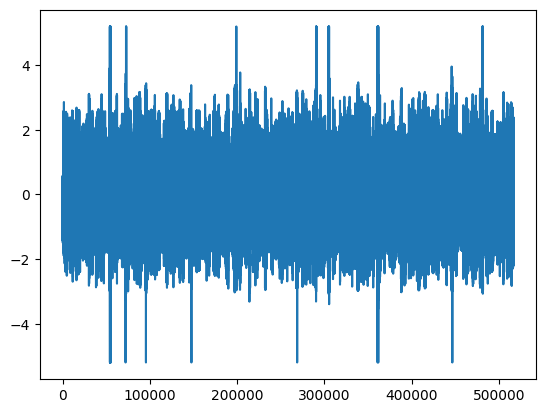

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('competition_package/datasets/train.csv')

timeseries = df[['0']].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [13]:
feature_cols = [col for col in df.columns if col not in ['seq_ix', 'step_in_seq', 'need_prediction']]
print(f"Number of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols[:5]}...")  # Show first 5

# Check data structure
print(f"\nTotal rows: {len(df)}")
print(f"Number of sequences: {df['seq_ix'].nunique()}")
print(f"Sequence length: {df.groupby('seq_ix').size().unique()}")  # Should all be 1000

Number of features: 32
Feature columns: ['0', '1', '2', '3', '4']...

Total rows: 517000
Number of sequences: 517
Sequence length: [1000]


In [14]:
# Cell 2: Split by sequences (NOT by time steps!)
# Get unique sequence IDs
unique_sequences = sorted(df['seq_ix'].unique())
print(f"Total sequences: {len(unique_sequences)}")

# Split sequences: 80% for training, 20% for validation
split_idx = int(len(unique_sequences) * 0.8)
train_seq_ids = unique_sequences[:split_idx]
val_seq_ids = unique_sequences[split_idx:]

print(f"Training sequences: {len(train_seq_ids)} (seq_ix: {train_seq_ids[0]} to {train_seq_ids[-1]})")
print(f"Validation sequences: {len(val_seq_ids)} (seq_ix: {val_seq_ids[0]} to {val_seq_ids[-1]})")

# Create train and validation dataframes
train_df = df[df['seq_ix'].isin(train_seq_ids)].copy()
val_df = df[df['seq_ix'].isin(val_seq_ids)].copy()

print(f"\nTraining data: {len(train_df)} rows")
print(f"Validation data: {len(val_df)} rows")

# Verify sequences are independent
print(f"\nTraining sequences: {train_df['seq_ix'].nunique()}")
print(f"Validation sequences: {val_df['seq_ix'].nunique()}")

Total sequences: 517
Training sequences: 413 (seq_ix: 0 to 412)
Validation sequences: 104 (seq_ix: 413 to 516)

Training data: 413000 rows
Validation data: 104000 rows

Training sequences: 413
Validation sequences: 104


In [ ]:
import torch

def create_sequence_dataset(df, lookback, feature_cols, min_step=0, max_step=None):
    """
    Create dataset for multi-feature prediction across all sequences.
    Processes each sequence independently and creates sliding windows.
    
    Args:
        df: DataFrame with columns ['seq_ix', 'step_in_seq', ...] + feature_cols
        lookback: Number of previous time steps to use as input
        feature_cols: List of column names to use as features
        min_step: Minimum step_in_seq to include (default 0, use 100 to skip warm-up)
        max_step: Maximum step_in_seq to include (default None = all)
    
    Returns:
        X: Tensor of shape (N, lookback, num_features)
        y: Tensor of shape (N, num_features)
        seq_ids: List of seq_ix for each sample (for sequence-aware training)
        
    """
    X, y, seq_ids = [], [], []
    
    # Group by sequence and process each sequence independently
    for seq_id in sorted(df['seq_ix'].unique()):
        sequence_df = df[df['seq_ix'] == seq_id].sort_values(by='step_in_seq')
        
        # Filter by step range if specified
        if min_step > 0:
            sequence_df = sequence_df[sequence_df['step_in_seq'] >= min_step]
        if max_step is not None:
            sequence_df = sequence_df[sequence_df['step_in_seq'] <= max_step]
        
        if len(sequence_df) < lookback + 1:
            continue  # Skip sequences that are too short
        
        # Extract features as numpy array
        features = sequence_df[feature_cols].values.astype('float32')
        
        # Create sliding windows for this sequence
        for i in range(len(features) - lookback):
            # Input: lookback steps of all features
            X.append(features[i : i + lookback])
            # Target: the next step's features (predicting step i+lookback)
            y.append(features[i + lookback])
            seq_ids.append(seq_id)
    
    # Convert to tensors efficiently
    X_array = np.array(X, dtype='float32')
    y_array = np.array(y, dtype='float32')
    
    return torch.tensor(X_array, dtype=torch.float32), torch.tensor(y_array, dtype=torch.float32), seq_ids

In [16]:
# Create datasets using all 31 features (or 32 if that's what we have)
lookback = 7

# Use all features except metadata columns
# Note: We'll use steps 0-999 for training (warm-up included for context)
# But we can filter to only predict on steps 100-999 if needed
X_train, y_train, train_seq_ids = create_sequence_dataset(
    train_df, lookback=lookback, feature_cols=feature_cols, min_step=0
)
X_val, y_val, val_seq_ids = create_sequence_dataset(
    val_df, lookback=lookback, feature_cols=feature_cols, min_step=0
)

print(f"Training dataset:")
print(f"  X_train shape: {X_train.shape}  # (samples, lookback, features)")
print(f"  y_train shape: {y_train.shape}  # (samples, features)")
print(f"  Number of features: {X_train.shape[-1]}")
print(f"  Number of training samples: {X_train.shape[0]}")

print(f"\nValidation dataset:")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  Number of validation samples: {X_val.shape[0]}")

Training dataset:
  X_train shape: torch.Size([410109, 7, 32])  # (samples, lookback, features)
  y_train shape: torch.Size([410109, 32])  # (samples, features)
  Number of features: 32
  Number of training samples: 410109

Validation dataset:
  X_val shape: torch.Size([103272, 7, 32])
  y_val shape: torch.Size([103272, 32])
  Number of validation samples: 103272


In [17]:
import torch.nn as nn

class MultiFeatureLSTM(nn.Module):
    """
    LSTM model for predicting all features simultaneously.
    Input: [batch, lookback, num_features]
    Output: [batch, num_features]
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # Output layer: maps hidden state to all features
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        # x: [batch, lookback, input_size]
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        # Take the output from the last timestep
        # lstm_out: [batch, lookback, hidden_size]
        # We want: [batch, hidden_size]
        last_hidden = lstm_out[:, -1, :]
        # Map to output features
        output = self.linear(last_hidden)  # [batch, input_size]
        return output

# Test the model with a sample input
num_features = X_train.shape[-1]
print(f"Number of features: {num_features}")

# Create a test model
test_model = MultiFeatureLSTM(
    input_size=num_features,
    hidden_size=64,
    num_layers=2,
    dropout=0.2
)

# Test forward pass
with torch.no_grad():
    test_input = X_train[:2]  # Take first 2 samples
    test_output = test_model(test_input)
    print(f"\nModel test:")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Output shape: {test_output.shape}")
    print(f"  Model created successfully!")


Number of features: 32

Model test:
  Input shape: torch.Size([2, 7, 32])
  Output shape: torch.Size([2, 32])
  Model created successfully!


In [18]:
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import r2_score
import numpy as np

def train_epoch(model, loader, optimizer, loss_fn, device='cpu'):
    """
    Train for one epoch with sequence-aware state reset.
    Resets hidden state when sequence changes.
    """
    model.train()
    total_loss = 0
    n_batches = 0
    
    # Track previous sequence ID to reset state
    prev_seq_id = None
    
    for batch_idx, (X_batch, y_batch, seq_batch) in enumerate(loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Reset hidden state if we've moved to a new sequence
        # Note: In practice, we batch samples from the same sequence together
        # For simplicity, we reset state between batches (can be optimized)
        # A more sophisticated approach would group by sequence
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches

def evaluate_model(model, X, y, seq_ids, device='cpu', feature_names=None):
    """
    Evaluate model and calculate R² per feature, then average.
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        # Process in batches to avoid memory issues
        batch_size = 128
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size].to(device)
            y_batch = y[i:i+batch_size].to(device)
            
            y_pred = model(X_batch)
            all_preds.append(y_pred.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    # Concatenate all predictions and targets
    y_pred_all = np.concatenate(all_preds, axis=0)
    y_true_all = np.concatenate(all_targets, axis=0)
    
    # Calculate R² for each feature
    num_features = y_pred_all.shape[1]
    r2_per_feature = []
    
    for feat_idx in range(num_features):
        r2 = r2_score(y_true_all[:, feat_idx], y_pred_all[:, feat_idx])
        r2_per_feature.append(r2)
    
    mean_r2 = np.mean(r2_per_feature)
    
    return mean_r2, r2_per_feature, y_pred_all, y_true_all

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
hidden_size = 128
num_layers = 2
dropout = 0.2
learning_rate = 0.001
batch_size = 32
n_epochs = 50

# Create model
model = MultiFeatureLSTM(
    input_size=num_features,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Create data loaders
# We include seq_ids in the dataset for potential sequence-aware batching
train_dataset = data.TensorDataset(X_train, y_train, torch.tensor(train_seq_ids))
val_dataset = data.TensorDataset(X_val, y_val, torch.tensor(val_seq_ids))

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"\nModel architecture:")
print(f"  Input size: {num_features} features")
print(f"  Hidden size: {hidden_size}")
print(f"  Number of layers: {num_layers}")
print(f"  Dropout: {dropout}")
print(f"\nTraining configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {learning_rate}")
print(f"  Number of epochs: {n_epochs}")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")

Using device: cpu

Model architecture:
  Input size: 32 features
  Hidden size: 128
  Number of layers: 2
  Dropout: 0.2

Training configuration:
  Batch size: 32
  Learning rate: 0.001
  Number of epochs: 50
  Training samples: 410109
  Validation samples: 103272


In [19]:
# Training loop
print("\n" + "="*60)
print("Starting training...")
print("="*60)

train_losses = []
val_r2_scores = []

for epoch in range(n_epochs):
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    
    # Evaluate on validation set every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        val_r2, val_r2_per_feat, _, _ = evaluate_model(
            model, X_val, y_val, val_seq_ids, device, feature_cols
        )
        val_r2_scores.append(val_r2)
        
        print(f"Epoch {epoch+1:3d}/{n_epochs} | "
              f"Train Loss: {train_loss:.6f} | "
              f"Val R²: {val_r2:.6f}")
    else:
        print(f"Epoch {epoch+1:3d}/{n_epochs} | Train Loss: {train_loss:.6f}")

print("\n" + "="*60)
print("Training completed!")
print("="*60)


Starting training...
Epoch   1/50 | Train Loss: 0.638300 | Val R²: 0.327865
Epoch   2/50 | Train Loss: 0.617787
Epoch   3/50 | Train Loss: 0.611245
Epoch   4/50 | Train Loss: 0.606799
Epoch   5/50 | Train Loss: 0.603021 | Val R²: 0.338458
Epoch   6/50 | Train Loss: 0.600138
Epoch   7/50 | Train Loss: 0.596738
Epoch   8/50 | Train Loss: 0.594280
Epoch   9/50 | Train Loss: 0.591699
Epoch  10/50 | Train Loss: 0.589377 | Val R²: 0.335518
Epoch  11/50 | Train Loss: 0.586590
Epoch  12/50 | Train Loss: 0.584013
Epoch  13/50 | Train Loss: 0.582216
Epoch  14/50 | Train Loss: 0.579888
Epoch  15/50 | Train Loss: 0.578199 | Val R²: 0.330017
Epoch  16/50 | Train Loss: 0.575937
Epoch  17/50 | Train Loss: 0.574777
Epoch  18/50 | Train Loss: 0.573288
Epoch  19/50 | Train Loss: 0.571549
Epoch  20/50 | Train Loss: 0.570606 | Val R²: 0.322135
Epoch  21/50 | Train Loss: 0.569376
Epoch  22/50 | Train Loss: 0.567511
Epoch  23/50 | Train Loss: 0.566917
Epoch  24/50 | Train Loss: 0.566313
Epoch  25/50 | Trai

In [ ]:
# Save the trained model for submission
import os

# Create a directory for model files if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save the model state dict
model_path = 'model/lstm_model.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Also save the model architecture parameters for loading
model_config = {
    'input_size': num_features,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'dropout': dropout
}

import json
with open('model/model_config.json', 'w') as f:
    json.dump(model_config, f)
print(f"Model config saved to model/model_config.json")


In [20]:
# Final evaluation on both train and validation sets
print("\n" + "="*60)
print("Final Evaluation")
print("="*60)

# Evaluate on training set
train_r2, train_r2_per_feat, y_pred_train, y_true_train = evaluate_model(
    model, X_train, y_train, train_seq_ids, device, feature_cols
)

# Evaluate on validation set
val_r2, val_r2_per_feat, y_pred_val, y_true_val = evaluate_model(
    model, X_val, y_val, val_seq_ids, device, feature_cols
)

print(f"\nOverall Results:")
print(f"  Training R²:   {train_r2:.6f}")
print(f"  Validation R²: {val_r2:.6f}")

# Show R² for first 10 features
print(f"\nR² per feature (first 10 features):")
for i in range(min(10, len(feature_cols))):
    feat_name = feature_cols[i]
    print(f"  Feature {feat_name:>3s}: Train R² = {train_r2_per_feat[i]:7.4f}, Val R² = {val_r2_per_feat[i]:7.4f}")

if len(feature_cols) > 10:
    print(f"  ... ({len(feature_cols) - 10} more features)")

# Summary statistics
print(f"\nR² Statistics:")
print(f"  Training - Min: {np.min(train_r2_per_feat):.4f}, Max: {np.max(train_r2_per_feat):.4f}, Std: {np.std(train_r2_per_feat):.4f}")
print(f"  Validation - Min: {np.min(val_r2_per_feat):.4f}, Max: {np.max(val_r2_per_feat):.4f}, Std: {np.std(val_r2_per_feat):.4f}")

print("\n" + "="*60)



Final Evaluation

Overall Results:
  Training R²:   0.458247
  Validation R²: 0.306021

R² per feature (first 10 features):
  Feature   0: Train R² =  0.3336, Val R² =  0.1863
  Feature   1: Train R² =  0.3666, Val R² =  0.2111
  Feature   2: Train R² =  0.3792, Val R² =  0.3217
  Feature   3: Train R² =  0.5526, Val R² =  0.4194
  Feature   4: Train R² =  0.3873, Val R² =  0.2075
  Feature   5: Train R² =  0.3635, Val R² =  0.2145
  Feature   6: Train R² =  0.5661, Val R² =  0.4364
  Feature   7: Train R² =  0.5728, Val R² =  0.4684
  Feature   8: Train R² =  0.4926, Val R² =  0.3545
  Feature   9: Train R² =  0.4872, Val R² =  0.2550
  ... (22 more features)

R² Statistics:
  Training - Min: 0.3336, Max: 0.5728, Std: 0.0732
  Validation - Min: 0.1634, Max: 0.4684, Std: 0.0836

